In [1]:
import os
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
def normalize_image(image, hdr_mode=False, normalization_policy='percentile'):
    if image.dtype == np.uint8:
        normalization_policy = "default"
    if normalization_policy.startswith("percentile") and hdr_mode:
        if image.dtype != np.float32 and image.dtype != np.uint32:
            raise ValueError('HDR image type is {} instead of float32 or uint32'.format(image.dtype))
        percentile_normalization_lower_bound = 0.1
        percentile_normalization_upper_bound = 99.5

        if normalization_policy == "percentile":
            lower_bound = np.array([np.percentile(image[..., i],
                                                  percentile_normalization_lower_bound,
                                                  interpolation='lower')
                                    for i in range(3)])
            upper_bound = np.array([np.percentile(image[..., i],
                                                  percentile_normalization_upper_bound,
                                                  interpolation='lower')
                                    for i in range(3)])
        elif normalization_policy == "percentile_vpu":
            r, g, b = image[..., 0], image[..., 1], image[..., 2]
            brightness = (3 * r + b + 4 * g) / 8
            lower_bound = np.percentile(brightness, percentile_normalization_lower_bound,
                                        interpolation='lower')
            upper_bound = np.percentile(brightness, percentile_normalization_upper_bound,
                                        interpolation='lower')

        image = (image.astype(np.float32) - lower_bound) / (upper_bound - lower_bound)
        image = np.clip(image, 0.0, 1.0)
    elif normalization_policy == "3sigma" and hdr_mode:
        if image.dtype != np.float32 and image.dtype != np.uint32:
            raise ValueError('HDR image type is {} instead of float32 or uint32'.format(image.dtype))
        sigma_size = 3
        min_variance = 1200
        r, g, b = image[...,0], image[...,1], image[...,2]
        brightness = (3 * r + b + 4 * g) / 8
        mean, sigma = np.mean(brightness), np.std(brightness)
        brightness_min, brightness_max = np.min(brightness), np.max(brightness)
        if (sigma * sigma_size) > mean:
            lmin = brightness_min
            lmax = min(brightness_max, mean * sigma_size)
            if (lmax - lmin) < min_variance:
                lmax = lmin + min_variance
            lower_bound = lmin
            upper_bound = lmax
        else:
            mean_var = mean - sigma_size * sigma
            output_min = max(brightness_min, mean_var)
            mean_var = mean + sigma_size * sigma
            output_max = min(brightness_max, mean_var)
            if (output_max - output_min) < min_variance:
                output_min = mean - min_variance / 2.0
                output_min = 0 if output_min < 0 else output_min
                output_max = output_min + min_variance
            lower_bound = output_min
            upper_bound = output_max
        image = (image.astype(np.float32) - lower_bound) / (upper_bound - lower_bound)
        image = np.clip(image, 0.0, 1.0)
    elif normalization_policy == 'tonemap' and hdr_mode:
        if image.dtype != np.float32 and image.dtype != np.uint32:
            raise ValueError('HDR image type is {} instead of float32 or uint32'.format(image.dtype))
        alpha = 0.5
        r, g, b = image[...,0], image[...,1], image[...,2]
        L_in = 0.27 * r + 0.67 * g + 0.06 * b
        Lw = np.exp(np.mean(np.log(L_in + 1e-6)))
        n = alpha * L_in / Lw
        L_out = n / (1 + n) * (1 + n / (n.max() ** 2))
        image = np.clip(image.astype(np.float32) * (L_out / L_in)[..., None], 0.0, 1.0)
    elif normalization_policy == "none" and hdr_mode:
        lower_bound = 0.0
        upper_bound = 2**20 - 1
        image = (image.astype(np.float32) - lower_bound) / (upper_bound - lower_bound)
        image = np.clip(image, 0.0, 1.0)
    elif normalization_policy == "default" or not hdr_mode:
        assert np.max(image) <= 255 and np.min(image) >= 0, \
            "Image with linear model should be in range [0,255]"
        lower_bound = 0.0
        upper_bound = 255.0
        image = (image.astype(np.float32) - lower_bound) / (upper_bound - lower_bound)
        image = np.clip(image, 0.0, 1.0)
    else:
        raise ValueError("normalization_policy is not supported!")
    return image

## Check image and label

In [2]:
root_dir = '/data/jupiter/datasets/Jupiter_train_v5_2/'
data_dir = os.path.join(root_dir, 'processed/images')
df = pd.read_csv(os.path.join(root_dir, '63c0b9af7d8cd7672e8c77cd_master_annotations.csv'), low_memory=False)
# df = df[df.hdr_mode == True]
df.shape

(241342, 269)

In [2]:
v53_df = pd.read_csv('/data/jupiter/datasets/Jupiter_train_v5_3/master_annotations.csv')
v51_df = pd.read_csv('/data/jupiter/datasets/Jupiter_train_v5_1/master_annotations.csv')
kids_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_kids_behind_vt_train_labelled/annotations.csv')
print(v53_df.shape, v51_df.shape, kids_df.shape)

/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (6,7,12,39,109,110,112,116,117,136,186,202,211) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (6,7,12,109,112,134,165,187) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(242894, 274) (208219, 247) (3116, 132)


In [3]:
v51_kids_df = v53_df[(v53_df.image_id.isin(v51_df.image_id)) | (v53_df.image_id.isin(kids_df.id))]
v51_kids_df.shape

(209777, 274)

In [4]:
v51_kids_df = v51_kids_df.sample(frac=1)
v51_kids_df.to_csv('/data/jupiter/datasets/Jupiter_train_v5_3/master_annotations_v51_and_kidsbehindimplement.csv', index=False)

In [5]:
iq_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_71/v471_iq.csv'
iq_df = pd.read_csv(iq_csv)
# bad_iq_df = iq_df[iq_df.iq != 'good']
sub_df1 = iq_df[(iq_df.iq_features_high > 0.2)]
sub_df2 = iq_df[(iq_df.iq_features_low > 0.9)]
sub_df3 = iq_df[(iq_df.iq_features_smudge > 90) & (iq_df.iq_features_smudge_reason == 'pixel_difference_on_gray_image')]
sub_df4 = iq_df[(iq_df.iq_features_smudge > 42) & (iq_df.iq_features_smudge_reason == 'pixel_difference_on_binary_image')]
sub_df5 = iq_df[(iq_df.iq_features_smudge > 8500) & (iq_df.iq_features_smudge < 458429) & (iq_df.iq_features_smudge_reason == 'adaptive_threshold')]
sub_df6 = iq_df[(iq_df.iq_features_smudge < 15) & (iq_df.iq_features_smudge_reason == 'blur')]
print(sub_df1.shape, sub_df2.shape, sub_df3.shape, sub_df4.shape, sub_df5.shape, sub_df6.shape)
bad_iq_df = pd.concat([sub_df1, sub_df2, sub_df3, sub_df4, sub_df5, sub_df6], ignore_index=True)
# # add back some human images
# human_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_53/humans.csv'
# human_df = pd.read_csv(human_csv)
# good_human_df = human_df[(human_df.human_pixel_count > 200) & (human_df.human_pixel_count < 15000)]
# bad_iq_df = bad_iq_df[~bad_iq_df.image_id.isin(good_human_df.image_id)]
df = df[~df.image_id.isin(bad_iq_df.image_id)]
print(df.shape)

# remove images likely miss human labels
fn_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_53/fn_strict.csv')
fp_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_53/fp_strict.csv')
hard_df = pd.concat([fn_df, fp_df], ignore_index=True)
df = df[~df.image_id.isin(hard_df.image_id)]
print(df.shape)

df.to_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_81_devised/master_annotations_cnp_reduced.csv', index=False)

(2822, 11) (5426, 11) (1718, 11) (357, 11) (307, 11) (251, 11)
(179935, 249)
(177862, 249)


In [7]:
dust_dict = {'image_id':[], 'dust_label':[], 'dust_ratio':[]}

for i,sample_df in tqdm(df.iterrows(), total=len(df)):
    if isinstance(sample_df.rectified_label_save_path, str):
        image_id = sample_df.image_id
        label_path = os.path.join(root_dir, sample_df.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        ids = np.unique(lbl)
        labelmap = json.loads(sample_df.label_map)
        labelmap_reverse = {v:int(k) for k,v in labelmap.items()}
        dust_light_id = labelmap_reverse.get("Dust and light artifacts", -1)
        dust_id = labelmap_reverse.get("Heavy Dust", -1)
        dust_dict['image_id'].append(image_id)
        dust_dict['dust_ratio'].append((lbl == dust_id).sum() / lbl.shape[0] / lbl.shape[1])
        if dust_light_id in ids and dust_id in ids:
            dust_dict['dust_label'].append('dust and dust_light')
        elif dust_light_id in ids:
            dust_dict['dust_label'].append('dust_light')
        elif dust_id in ids:
            dust_dict['dust_label'].append('dust')
        else:
            dust_dict['dust_label'].append('no dust')
dust_df = pd.DataFrame(data=dust_dict)
dust_df = dust_df.merge(df[['image_id', 'camera_location', 'operation_time']], on='image_id')
dust_df.to_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_71/dust_label.csv', index=False)
print(dust_df.shape)
dust_df.groupby('dust_label').count()

(195289, 5)


,image_id,dust_ratio,camera_location,operation_time
dust_label,,,,
dust,6375,6375,6375,6154
dust and dust_light,2053,2053,2053,2050
dust_light,12881,12881,12881,12795
no dust,173980,173980,173980,145534


(512, 1024, 3) (512, 1024, 1)
5f5ffba857a4a852f9ffc59d [ 0  1  2  4 13 14 15 16 17 20 21]


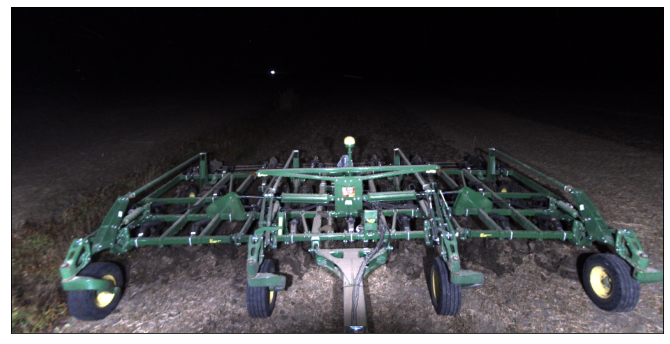

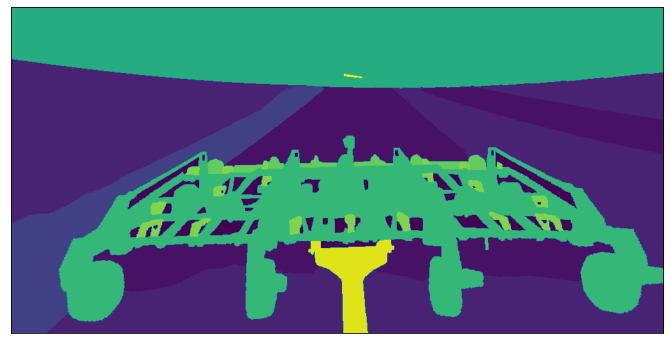

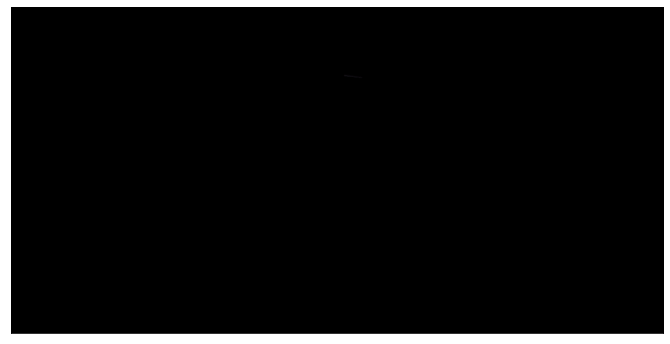

In [12]:
# image_id = '5df923b980a73f861bcd2a0b'
# image_id = '5df923b980a73f861bcd166c'  # left and right mismatch
# image_id = '5f41958c1823a9871daa1ec9'  # wrong dust
cnt = 0
# sample_df = df[df.image_id == image_id].iloc[0]
for i,sample_df in df.sample(1).iterrows():
    image_id = sample_df.image_id
    data_path = os.path.join(root_dir, 'processed/images', image_id, 'stereo_output.npz')
    img = np.load(data_path)['left']
    img = normalize_image(img, sample_df.hdr_mode)
    if isinstance(sample_df.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, sample_df.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        if np.any(lbl == 21) and cnt < 10:
    #     if np.all(lbl != 11):
            cnt += 1

            print(img.shape, lbl.shape)
            img = cv2.resize(img, (1024, 512))
            lbl = cv2.resize(lbl, (1024, 512))
            mask = np.repeat(lbl[:,:,np.newaxis] == 21, 3, axis=2)
            img3 = img.copy()
            img3[~mask] = 0

            print(image_id, np.unique(lbl))
            plt.figure(figsize=(12, 6))
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.show()
            plt.figure(figsize=(12, 6))
            plt.imshow(lbl)
            plt.xticks([])
            plt.yticks([])
            plt.show()
            plt.figure(figsize=(12, 6))
            plt.imshow(img3)
            plt.xticks([])
            plt.yticks([])
            plt.show()
        if cnt == 10:
            break
    else:
        print(image_id)
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

## Verify removing bad iq images

In [6]:
cur_csv = '/data/jupiter/datasets/Jupiter_train_v4_71/master_annotations_v4_73.csv'
cur_df = pd.read_csv(cur_csv, low_memory=False)
cur_df_cpy = cur_df.copy()
cur_df.shape

(195289, 234)

In [7]:
# remove bad iq images
iq_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_53/v453_iq.csv'
# iq_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_71/v471_iq.csv'
iq_df = pd.read_csv(iq_csv)
bad_iq_df = iq_df[iq_df.iq != 'good']
# # add back some human images
# human_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_53/humans.csv'
# human_df = pd.read_csv(human_csv)
# good_human_df = human_df[(human_df.human_pixel_count > 200) & (human_df.human_pixel_count < 15000)]
# bad_iq_df = bad_iq_df[~bad_iq_df.image_id.isin(good_human_df.image_id)]
cur_df = cur_df[~cur_df.image_id.isin(bad_iq_df.image_id)]
print(cur_df.shape)

(177895, 234)


In [8]:
# remove images likely miss human labels
fn_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_53/fn_strict.csv')
fp_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_53/fp_strict.csv')
hard_df = pd.concat([fn_df, fp_df], ignore_index=True)
cur_df = cur_df[~cur_df.image_id.isin(hard_df.image_id)]
print(cur_df.shape)

(175831, 234)


In [8]:
diff_df = cur_df_cpy[~cur_df_cpy.image_id.isin(cur_df.image_id)]
print(diff_df.shape)
diff_df[['image_id']].to_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_53/471_removed.csv', index=False)

(19458, 234)


## Check difference in relabeled images and labels

In [3]:
new_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_53/Jupiter_train_v4_53_heavy_dust_relabeled/master_annotations.csv'
new_df = pd.read_csv(new_csv, low_memory=False)
new_df.shape

(4990, 227)

In [4]:
set(cur_df.columns) - set(new_df.columns)

{'aletheia_datapoint_id',
 'annotation_pixelwise_0_aletheia_id',
 'controller_version',
 'event_type',
 'exposure_human_tagged',
 'jupiter_interface_foxy_branch',
 'jupiter_interface_foxy_hash',
 'jupiter_metadata_schema',
 'lens_flare_human_tagged',
 'plug_human_tagged'}

In [15]:
cur_df[['stereo_left_image', 'stereo_pipeline_npz_save_path', 'label_save_path', 'rectified_label_save_path']].sample(2)

,stereo_left_image,stereo_pipeline_npz_save_path,label_save_path,rectified_label_save_path
69724,images/5f6009fc3e26e3a7af4d5af1/artifact_rgb_0...,processed/images/5f6009fc3e26e3a7af4d5af1/ster...,images/5f6009fc3e26e3a7af4d5af1/annotation_pix...,processed/images/5f6009fc3e26e3a7af4d5af1/rect...
96626,images/5f615736df10fb696ea6c82c/artifact_rgb_0...,processed/images/5f615736df10fb696ea6c82c/ster...,images/5f615736df10fb696ea6c82c/annotation_pix...,processed/images/5f615736df10fb696ea6c82c/rect...


In [16]:
new_df[['stereo_left_image', 'stereo_pipeline_npz_save_path', 'label_save_path', 'rectified_label_save_path']].sample(2)

,stereo_left_image,stereo_pipeline_npz_save_path,label_save_path,rectified_label_save_path
3197,images/606df316036e8998300af5d4/artifact_rgb_0...,processed/images/606df316036e8998300af5d4/ster...,images/606df316036e8998300af5d4/annotation_pix...,processed/images/606df316036e8998300af5d4/rect...
510,images/5f6a853c3af6a33bf44fae75/artifact_rgb_0...,processed/images/5f6a853c3af6a33bf44fae75/ster...,images/5f6a853c3af6a33bf44fae75/annotation_pix...,processed/images/5f6a853c3af6a33bf44fae75/rect...


In [17]:
print(cur_df[['stereo_pipeline_npz_save_path']].sample(2).stereo_pipeline_npz_save_path.to_list())
print(cur_df[['rectified_label_save_path']].sample(2).rectified_label_save_path.to_list())


['processed/images/606798d9b71d94a6732eea53/stereo_output.npz', 'processed/images/5f6165b84c1bf5f0ef28a14d/stereo_output.npz']
['processed/images/611acf5caf0cb6b660856abc/rectification_output_61e6500bce4ea158fe076b07.npz', 'processed/images/5f94f473e7e0ed01f2441c94/rectification_output_6007d4b51126d61edb9427e7.npz']


In [18]:
print(new_df[['stereo_pipeline_npz_save_path']].sample(2).stereo_pipeline_npz_save_path.to_list())
print(new_df[['rectified_label_save_path']].sample(2).rectified_label_save_path.to_list())

['processed/images/5fe3c3248e1ea3374903e92d/stereo_output.npz', 'processed/images/5fe4239d9cd759cacdce8c83/stereo_output.npz']
['processed/images/5f616b46aae46e99ef552ae6/rectification_output_62cca6964a0a6c5c80959138.npz', 'processed/images/61c23d536f194498d00d043c/rectification_output_62cca680cf9f2e260c089da1.npz']


In [58]:
data_dir1 = '/data/jupiter/datasets/Jupiter_train_v4_71'
# data_dir2 = '/data/jupiter/li.yu/data/Jupiter_train_v4_53/Jupiter_train_v4_53_missing_human_relabeled'
data_dir2 = '/data/jupiter/li.yu/data/Jupiter_train_v4_53/Jupiter_train_v4_53_heavy_dust_relabeled'
new_df = pd.read_csv(os.path.join(data_dir2, 'master_annotations.csv'))
image_ids = new_df.image_id.to_list()
print(new_df.shape, len(image_ids))

(4990, 227) 4990


/tmp/ipykernel_83395/4077396494.py:4: DtypeWarning: Columns (4,5,85,100,105,125,175,181) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(os.path.join(data_dir2, 'master_annotations.csv'))


In [36]:
def plot_rgb(gray):
    plt.figure(1, figsize=(12, 6))
    plt.imshow(gray)
    plt.show()

def plot_gray(gray):
    plt.figure(1, figsize=(12, 6))
    plt.imshow(gray, cmap='gray')
    plt.show()

processed/images/5f10f35d87616e19a40d985f/stereo_output.npz processed/images/5f10f35d87616e19a40d985f/stereo_output.npz
0.0


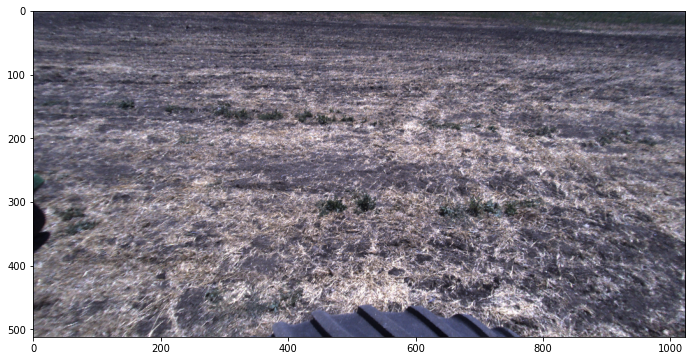

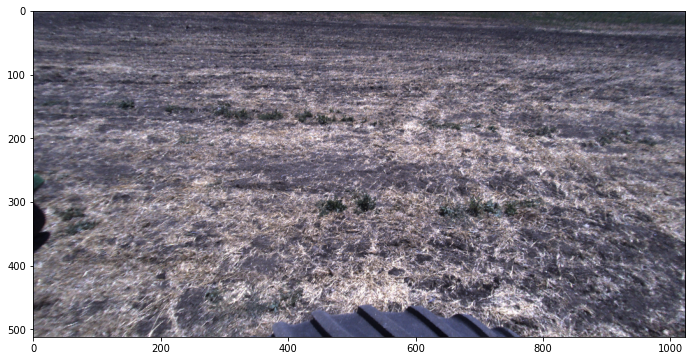

In [41]:
image_id = random.sample(image_ids, 1)[0]
image_path1 = cur_df[cur_df.image_id == image_id].iloc[0].stereo_pipeline_npz_save_path
image_path2 = new_df[new_df.image_id == image_id].iloc[0].stereo_pipeline_npz_save_path
image1 = np.load(os.path.join(data_dir1, image_path1))['left']
image2 = np.load(os.path.join(data_dir2, image_path2))['left']
print(image_path1, image_path2)
print(np.sum(np.abs(image1 - image2)))
plot_rgb(image1/image1.max())
plot_rgb(image2/image2.max())

processed/images/5f10f35d87616e19a40d985f/rectification_output_5f165f957cf61359f52c7c6d.npz processed/images/5f10f35d87616e19a40d985f/rectification_output_62c6129aa56794f02091c63c.npz
[ 2 14 19] [ 2 14 19]


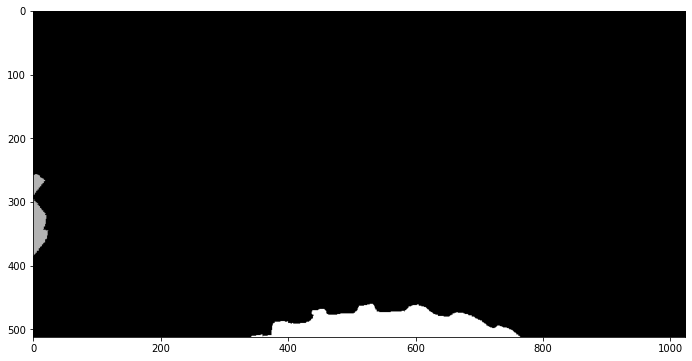

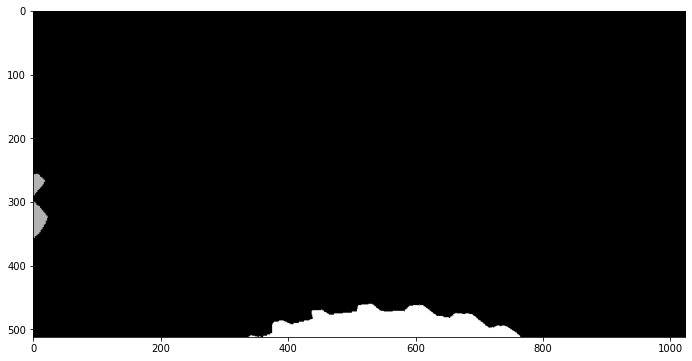

In [42]:
# image_id = random.sample(image_ids, 1)[0]
label_path1 = cur_df[cur_df.image_id == image_id].iloc[0].rectified_label_save_path
label_path2 = new_df[new_df.image_id == image_id].iloc[0].rectified_label_save_path
label1 = np.load(os.path.join(data_dir1, label_path1))['left'][:,:,0]
label2 = np.load(os.path.join(data_dir2, label_path2))['left'][:,:,0]
print(label_path1, label_path2)
print(np.unique(label1), np.unique(label2))
plot_gray(label1)
plot_gray(label2)

### copy rectified npz files to source folder

In [59]:
cnt = 0
for image_id in image_ids:
    label_path2 = new_df[new_df.image_id == image_id].iloc[0].rectified_label_save_path
    label_full_path2 = os.path.join(data_dir2, label_path2)
    label_dir1 = os.path.join(data_dir1, 'processed/images', image_id)
    if not os.path.isfile(os.path.join(data_dir1, label_path2)):
        shutil.copy(label_full_path2, label_dir1)
        # print(label_path2)
        # print(cur_df[cur_df.image_id == image_id].iloc[0]['rectified_label_save_path'])
        cur_df.loc[cur_df.image_id == image_id, 'rectified_label_save_path'] = label_path2
        # print(cur_df[cur_df.image_id == image_id].iloc[0]['rectified_label_save_path'])
        # break
        cnt += 1
print(cnt, len(image_ids))


4859 4990


In [60]:
cur_df.to_csv('/data/jupiter/datasets/Jupiter_train_v4_71/master_annotations_v4_74.csv', index=False)

In [64]:
cur_csv = '/data/jupiter/datasets/Jupiter_train_v4_71/master_annotations_v4_74.csv'
cur_df = pd.read_csv(cur_csv)
old_cur_csv = '/data/jupiter/datasets/Jupiter_train_v4_71/master_annotations.csv'
old_cur_df = pd.read_csv(old_cur_csv)
idx = []
for i in tqdm(range(len(cur_df)), total=len(cur_df)):
    if cur_df.iloc[i].image_id != old_cur_df.iloc[i].image_id:
        print(i)
    if cur_df.iloc[i].rectified_label_save_path != old_cur_df.iloc[i].rectified_label_save_path:
        idx.append(i)
print(len(idx))

/tmp/ipykernel_83395/3428124356.py:2: DtypeWarning: Columns (20,34,103,106,152,172,226,231,232,233) have mixed types. Specify dtype option on import or set low_memory=False.
  cur_df = pd.read_csv(cur_csv)
/tmp/ipykernel_83395/3428124356.py:4: DtypeWarning: Columns (20,34,103,106,152,172,226,231,232,233) have mixed types. Specify dtype option on import or set low_memory=False.
  old_cur_df = pd.read_csv(old_cur_csv)
100%|██████████| 195289/195289 [01:46<00:00, 1836.24it/s]

7005


## Check image / label mismatch in training data

In [11]:
sample_df = df[df.image_id == '5df923b980a73f861bcd2a0b'].iloc[0]
image_id = sample_df.image_id

# sample_df = df.iloc[0]
# image_id = sample_df.image_id

raw = cv2.imread(os.path.join(root_dir, sample_df.stereo_left_image))
data_path = os.path.join(root_dir, 'processed/images', image_id, 'stereo_output.npz')
img = np.load(data_path)['left']
img = normalize_image(img, sample_df.hdr_mode)
label_path = os.path.join(root_dir, sample_df.rectified_label_save_path)
lbl = np.load(label_path)['left']
print(image_id, np.unique(lbl))

plt.figure(figsize=(12, 6))
plt.imshow(cv2.resize(raw, (1024, 512)))
plt.xticks([])
plt.yticks([])
plt.show()
plt.figure(figsize=(12, 6))
plt.imshow(cv2.resize(img, (1024, 512)))
plt.xticks([])
plt.yticks([])
plt.show()
plt.figure(figsize=(12, 6))
plt.imshow(cv2.resize(lbl, (1024, 512)))
plt.xticks([])
plt.yticks([])
plt.show()


5df923b980a73f861bcd2a0b [ 0  2  5  6  7 11]


[ WARN:0@477.160] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/jupiter/datasets/Jupiter_train_v4_81_devised/images/5df923b980a73f861bcd2a0b/artifact_rgb_0_5df923b980a73f861bcd2a0b.png'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


<Figure size 864x432 with 0 Axes>

In [40]:
print(raw.shape)
img.shape, lbl.shape

(1080, 1920, 3)


((512, 1024, 3), (512, 1024, 1))

In [ ]:
''' save raw shape
(540, 960, 3)

'''

''' wrong image / label
5fa652b16330d022ca7d5f78
'''

In [13]:
shape_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_71/shape.csv')
print(shape_df.shape)
shape_df.groupby(['label_shape', 'raw_shape']).count()

(195289, 4)


image_id  image_shape
label_shape  raw_shape                          
(1080, 1920) (1080, 1920)     26914        26914
(1208, 1928) (1208, 1928)     28204        28204
             (604, 960)        3540         3540
(512, 1024)  (1080, 1920)      1451         1451
             (512, 1024)      84525        84525
             (540, 960)       49156        49156
             (604, 992)        1499         1499

In [18]:
shape_df[(shape_df.label_shape == '(1208, 1928)') & (shape_df.raw_shape == '(1208, 1928)')].sample(5)

,image_id,image_shape,label_shape,raw_shape
23421,5e20e7ec47c13332fde0ba4e,"(512, 1024)","(1208, 1928)","(1208, 1928)"
191181,61694ae752252b4dee7851f2,"(512, 1024)","(1208, 1928)","(1208, 1928)"
86362,5df9238180a73f861bcc0d61,"(512, 1024)","(1208, 1928)","(1208, 1928)"
4083,5df92c1a80a73f861b0ce66b,"(512, 1024)","(1208, 1928)","(1208, 1928)"
39618,5ec49e4cce7cf4e480e11146,"(512, 1024)","(1208, 1928)","(1208, 1928)"


In [15]:
shape_df[shape_df.image_id == '5df9242880a73f861bd0817e']

,image_id,image_shape,label_shape,raw_shape
152993,5df9242880a73f861bd0817e,"(512, 1024)","(1208, 1928)","(1208, 1928)"


In [2]:
data_dir = '/data/jupiter/li.yu/data/all_hitchhiker_left_images_location_filtered_20220729'
df = pd.read_csv(os.path.join(data_dir, 'annotations.csv'), low_memory=False)
df.shape

(1361793, 77)

In [6]:
# merge with dust prediction csv
pred_csv = '/data/jupiter/li.yu/exps/driveable_terrain_model/v471_rd_2cls_dustseghead_0808/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'
pred_df = pd.read_csv(pred_csv, low_memory=False)
print(pred_df.shape)
df = df.merge(pred_df, on='id')
df.shape

(1361793, 6)


(1361793, 82)

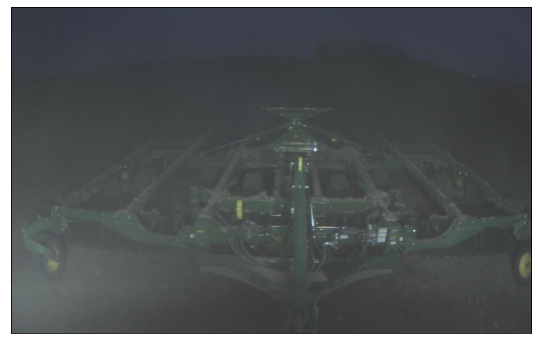

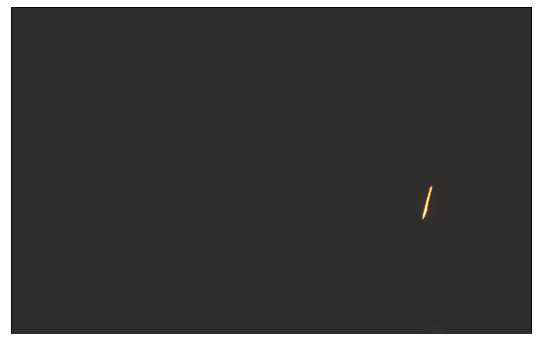

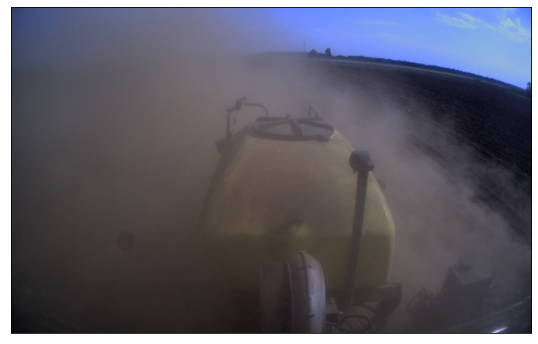

,id
7800,62bf5622b25f7fed57c0de5b
1122913,62bf732aeb6c58f4e39af481
807399,62be203e99b4454e86eed3da


In [13]:
def plot_images(df):
    for i,row in df.iterrows():
        img_path = os.path.join(data_dir, row['artifact_debayeredrgb_0_save_path'])
        image = imageio.imread(img_path)
        plt.figure(figsize=(12, 6))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()

sub_df = df[(~df.camera_location.str.startswith('front')) & (df.dust_ratio > 0.2)].sample(3)
plot_images(sub_df)
sub_df[['id']]

## Check debayered image and label

In [22]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    if isinstance(row.artifact_debayeredrgb_0_save_path, str):
        image = imageio.imread(os.path.join(root_dir, row.artifact_debayeredrgb_0_save_path))
    else:
        image = imageio.imread(os.path.join(root_dir, row.artifact_rgb_0_save_path))
    if not isinstance(image, np.ndarray):
        print(i, row.image_id)

  5%|▍         | 8883/195289 [06:54<2:15:28, 22.93it/s]

In [10]:
i = 10000
print(df.iloc[i].image_id, df.iloc[i].hdr_mode)
stereo_data = np.load(os.path.join(root_dir, df.iloc[i].stereo_pipeline_npz_save_path))
image = stereo_data['left']
image = normalize_image(image, df.iloc[i].hdr_mode, 'percentile')
# image = imageio.imread(os.path.join(root_dir, df.iloc[i].artifact_debayeredrgb_0_save_path))
# image = imageio.imread(os.path.join(root_dir, df.iloc[i].artifact_rgb_0_save_path))
# image = imageio.imread(os.path.join(root_dir, df.iloc[i].stereo_left_image))
label = imageio.imread(os.path.join(root_dir, df.iloc[i].label_save_path))
image.shape, label.shape, image.dtype, image.min(), image.max()

61c3dde0a8fbb9ae1f6e839c True


((512, 1024, 3), (540, 960), dtype('float32'), 0.0, 1.0)

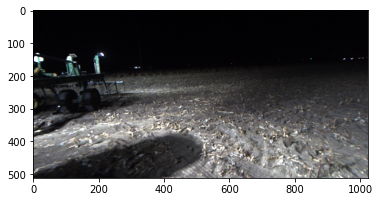

In [11]:
# debayered
plt.imshow(image)
plt.show()
# plt.imshow(label)
# plt.show()

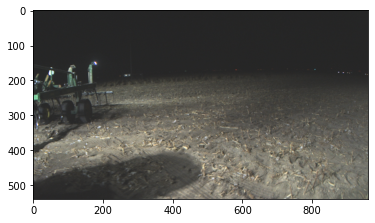

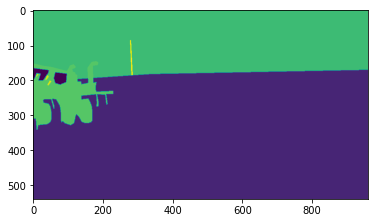

In [6]:
# rectified
plt.imshow(image)
plt.show()
# plt.imshow(label)
# plt.show()

In [4]:
prefix = 's3://blueriver-jupiter-data/pack_perception/ml/c237d42b157238f8f8dc246f8edd114a_f7f06940b2bcf0b2d8c8739378ce8c44/processed/images'
data_dir = '/data/jupiter/li.yu/data/Jupiter_vt_dust_8_10mph_Jan2023_2/processed/images'
df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_vt_dust_8_10mph_Jan2023_2/master_annotations.csv')
print(df.shape)
with open('./download.sh', 'w') as f:
    for i,row in df.iterrows():
        f.write(f'aws s3 cp {prefix}/{row.image_id}/stereo_output.npz {data_dir}/{row.image_id}/\n')

(21499, 126)
